In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import sparse
%matplotlib inline
seed = 2390

In [4]:
path = './data/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

In [5]:
vect_word = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,1),dtype=np.float32)
vect_word1 = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,2),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=10000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(1,4),dtype=np.float32)

In [6]:
#vect_word.fit(list(train['comment_text']) + list(test['comment_text']))
tr_vect = vect_word.fit_transform(train['comment_text'])
ts_vect = vect_word.transform(test['comment_text'])

tr_vect1 = vect_word1.fit_transform(train['comment_text'])
ts_vect1 = vect_word1.transform(test['comment_text'])

#vect_char.fit(list(train['comment_text']) + list(test['comment_text']))
tr_vect_char = vect_char.fit_transform(train['comment_text'])
ts_vect_char = vect_char.transform(test['comment_text'])

In [7]:
X = sparse.hstack([tr_vect,tr_vect1, tr_vect_char])
x_test = sparse.hstack([ts_vect,ts_vect1, ts_vect_char])

In [8]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train[target_col]
del tr_vect, ts_vect, tr_vect_char, ts_vect_char

In [9]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    lr = LogisticRegression(C=20,random_state = i,class_weight = 'balanced')
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]

Building 0 model for column:toxic
Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


In [10]:
col = 'identity_hate'
print("Column:",col)
pred =  lr.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

Column: identity_hate

Confusion matrix
 [[157650    516]
 [     0   1405]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    158166
          1       0.73      1.00      0.84      1405

avg / total       1.00      1.00      1.00    159571



Column: identity_hate


Text(0.5,1,'Reciever Operating Characteristic')

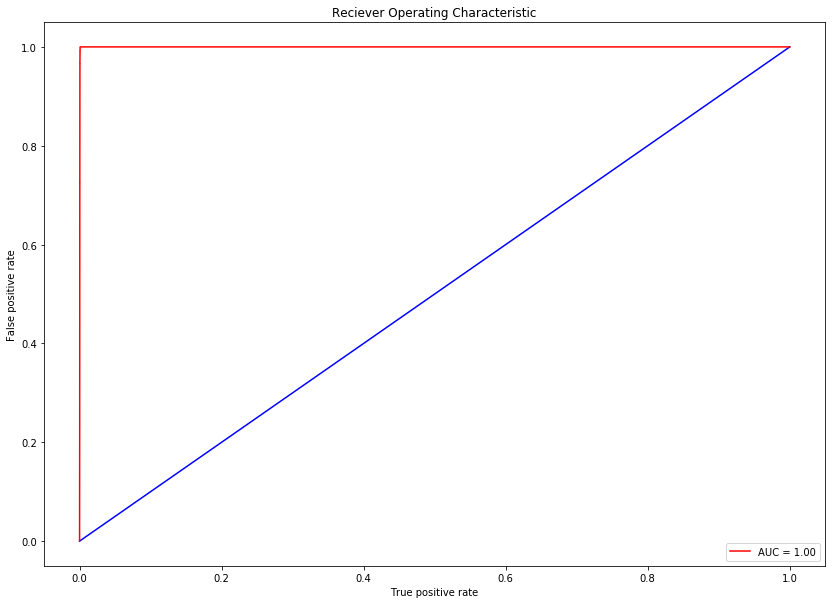

In [11]:
col = 'identity_hate'
print("Column:",col)
pred_pro = lr.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

In [12]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([test['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
submit.to_csv('toxic_lr.csv',index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.635661,1.000000,2.098483e-01,0.999855,9.836695e-01
1,0000247867823ef7,0.003863,0.000017,0.000002,2.065651e-07,0.000202,9.085152e-05
2,00013b17ad220c46,0.002025,0.000089,0.004443,5.117698e-08,0.002233,7.451240e-04
3,00017563c3f7919a,0.000125,0.001717,0.000110,2.608440e-05,0.000079,3.009272e-07
4,00017695ad8997eb,0.000085,0.000140,0.000032,3.574352e-06,0.001723,3.411474e-07


In [17]:
submit2 = submit

In [18]:
submit2['severe_toxic'] = submit[['toxic', 'severe_toxic']].min(axis=1)

In [19]:
submit2.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.635661,1.000000,2.098483e-01,0.999855,9.836695e-01
1,0000247867823ef7,0.003863,0.000017,0.000002,2.065651e-07,0.000202,9.085152e-05
2,00013b17ad220c46,0.002025,0.000089,0.004443,5.117698e-08,0.002233,7.451240e-04
3,00017563c3f7919a,0.000125,0.000125,0.000110,2.608440e-05,0.000079,3.009272e-07
4,00017695ad8997eb,0.000085,0.000085,0.000032,3.574352e-06,0.001723,3.411474e-07


In [20]:
submit2.to_csv("toxic_lr2.csv", index=False)

In [34]:
fk = pd.concat([submit2, test['comment_text']], axis=1)

In [40]:
fk.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,00001cee341fdb12,1.000000,0.635661,1.000000,2.098483e-01,0.999855,9.836695e-01,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,0.003863,0.000017,0.000002,2.065651e-07,0.000202,9.085152e-05,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,0.002025,0.000089,0.004443,5.117698e-08,0.002233,7.451240e-04,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,0.000125,0.000125,0.000110,2.608440e-05,0.000079,3.009272e-07,":If you have a look back at the source, the in..."
4,00017695ad8997eb,0.000085,0.000085,0.000032,3.574352e-06,0.001723,3.411474e-07,I don't anonymously edit articles at all.


In [43]:
fk2 = fk.loc[fk['comment_text'].str.lower().str.find('fuck') != -1]

In [44]:
fk2.loc[fk2['toxic']<0.5]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
255,007021b91a4a3cf7,0.068301,5.067922e-06,0.000085,4.171535e-06,0.000022,5.257744e-05,""" \n ::Lol, and there we have it, right on tim..."
807,015474aec031c024,0.001443,1.443461e-03,0.044527,3.190808e-06,0.001249,8.411199e-06,""" \n\n ==Barnstar== \n {| style=""""border: 1px ..."
858,016b09d531283f37,0.000205,2.052792e-04,0.045523,2.594400e-06,0.002870,3.081934e-08,""" \n\n ==WikiProject Red Hot Chili Peppers Sep..."
3195,057e957829e115ba,0.000965,1.576339e-06,0.157321,3.306621e-05,0.004993,7.303227e-01,"""Hello, below is something I wrote a while bac..."
3551,061d0de763f012d6,0.217691,2.275638e-05,0.037245,2.136158e-06,0.007534,8.124868e-04,""" \n\n == Turkish tag on this page == \n\n Med..."
3817,068e126851caf8f8,0.075131,5.818847e-04,0.002035,5.716910e-05,0.002249,1.434783e-06,""" \n\n == Listen you ignorant motherfuckers......"
3862,069ea6e14702c595,0.457764,3.913588e-04,0.553049,2.650914e-06,0.259716,3.085677e-03,":Sorry, one clusterfuck of an off-wiki-POV-war..."
3894,06a95436fa2262d0,0.460106,6.351637e-06,0.002230,3.638075e-05,0.046299,6.643276e-06,""" \n The """"feeling better"""" comment impugns ex..."
4376,07722d2cb9393b11,0.354562,2.337842e-07,0.026919,4.030925e-06,0.000329,2.564285e-04,I'll remove it - I cannot see it in a quick sc...
4588,07ccb3719ae6a407,0.025054,1.236208e-03,0.360613,3.265396e-05,0.001923,5.249568e-04,== Masonic censorship == \n\n A cabal of goat ...


In [28]:
fk = submit2.loc[test['comment_text'].str.find('fuck') != -1]

C:\Users\sweetcocoa\Anaconda3\envs\torch\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
255,007021b91a4a3cf7,0.068301,5.067922e-06,0.000085,4.171535e-06,0.000022,5.257744e-05
858,016b09d531283f37,0.000205,2.052792e-04,0.045523,2.594400e-06,0.002870,3.081934e-08
3195,057e957829e115ba,0.000965,1.576339e-06,0.157321,3.306621e-05,0.004993,7.303227e-01
3551,061d0de763f012d6,0.217691,2.275638e-05,0.037245,2.136158e-06,0.007534,8.124868e-04
3817,068e126851caf8f8,0.075131,5.818847e-04,0.002035,5.716910e-05,0.002249,1.434783e-06
3862,069ea6e14702c595,0.457764,3.913588e-04,0.553049,2.650914e-06,0.259716,3.085677e-03
3894,06a95436fa2262d0,0.460106,6.351637e-06,0.002230,3.638075e-05,0.046299,6.643276e-06
4376,07722d2cb9393b11,0.354562,2.337842e-07,0.026919,4.030925e-06,0.000329,2.564285e-04
4588,07ccb3719ae6a407,0.025054,1.236208e-03,0.360613,3.265396e-05,0.001923,5.249568e-04
4921,0850b69c7424a49a,0.284501,6.621374e-06,0.322344,3.990779e-06,0.022925,1.258042e-05
